الكود الي حشتغل عليه  ونعتمدا


الكود معا تحسيين الجودة

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

# Standard libraries
import os
import shutil
import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Computer visionن
import cv2
from PIL import Image, ImageEnhance, ImageFilter  # الإضافة الجديدة



# Scikit-learn
from sklearn.utils import compute_class_weight
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input



In [ ]:
# ✅ ربط Google Colab مع Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ✅ تحديد مسار مجلد البيانات داخل الدرايف
BASE_PATH = "/content/drive/MyDrive/brain_tumor_dataset/dataset"

# التحقق من المجلدات داخله (Training / Testing)
print("📂 المحتويات داخل مجلد البيانات:")
print(os.listdir(BASE_PATH))

# ✅ تحديد مسارات الـ Training و Testing
train_dir = os.path.join(BASE_PATH, "Training")
test_dir = os.path.join(BASE_PATH, "Testing")

print("\n✅ مسار التدريب:", train_dir)
print("✅ مسار الاختبار:", test_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 المحتويات داخل مجلد البيانات:
['Testing', 'Training', '.tmp.driveupload']

✅ مسار التدريب: /content/drive/MyDrive/brain_tumor_dataset/dataset/Training
✅ مسار الاختبار: /content/drive/MyDrive/brain_tumor_dataset/dataset/Testing


In [ ]:
# مسارات البيانات
train_dir = '/content/drive/MyDrive/brain_tumor_dataset/dataset/Training'
test_dir  = '/content/drive/MyDrive/brain_tumor_dataset/dataset/Testing'

# التحقق من محتوى المجلدات
import os

print("محتويات مجلد التدريب:", os.listdir(train_dir))
print("محتويات مجلد الاختبار:", os.listdir(test_dir))


محتويات مجلد التدريب: ['pituitary', 'notumor', 'meningioma', 'glioma']
محتويات مجلد الاختبار: ['notumor', 'glioma', 'meningioma', 'pituitary']


In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

# ------------------------------
# إعداد المسارات والفئات
# ------------------------------
import os
#    لأنه يحتوي بداخله على مجلدات 'Training' و 'Testing'.
data_dir = '/content/drive/MyDrive/brain_tumor_dataset/dataset'

# 🚨 2. تعريف مسار الإخراج (Output Base) لتجنب NameError
output_base = '/content/drive/MyDrive/brain_tumor_dataset/Split_Output/'
# تأكد من أن هذا المسار موجود أو سيتم إنشاؤه.

# إنشاء مجلد الإخراج الأساسي
os.makedirs(output_base, exist_ok=True)

train_dir = os.path.join(output_base, 'train')
validation_dir = os.path.join(output_base, 'validation')
test_dir = os.path.join(output_base, 'test')

categories = ['pituitary', 'notumor', 'meningioma', 'glioma']

# نسب التقسيم
train_ratio = 0.8
validation_ratio = 0.2

# امتدادات الملفات المقبولة
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')

# ------------------------------
# دوال مساعدة
# ------------------------------
def ensure_dir(path):
    """إنشاء مجلد إذا لم يكن موجودًا"""
    os.makedirs(path, exist_ok=True)

def copy_files(file_list, src_dir, dest_dir, category):
    """نسخ الملفات مع التحقق من عدم التكرار"""
    dest_category_dir = os.path.join(dest_dir, category)
    ensure_dir(dest_category_dir)
    for file in file_list:
        src_path = os.path.join(src_dir, file)
        dst_path = os.path.join(dest_category_dir, file)
        if not os.path.exists(dst_path):
            shutil.copy2(src_path, dst_path)

# ------------------------------
# تقسيم البيانات
# ------------------------------
for category in categories:
    # سيحاول البحث الآن في: /.../dataset/Training/category
    train_category_path = os.path.join(data_dir, 'Training', category)
    # سيحاول البحث الآن في: /.../dataset/Testing/category
    test_category_path = os.path.join(data_dir, 'Testing', category)
    # التحقق من وجود مجلد التدريب
    if os.path.exists(train_category_path):
        image_files = [f for f in os.listdir(train_category_path) if f.lower().endswith(valid_extensions)]
        if len(image_files) == 0:
            print(f"⚠️ لا توجد صور صالحة في {train_category_path}")
            continue

        # تقسيم التدريب والتحقق باستخدام sklearn
        train_files, val_files = train_test_split(
            image_files,
            test_size=validation_ratio,
            random_state=42,
            shuffle=True
        )

        copy_files(train_files, train_category_path, train_dir, category)
        copy_files(val_files, train_category_path, validation_dir, category)
    else:
        print(f"❌ مجلد التدريب غير موجود للفئة: {category}")

    # التحقق من وجود مجلد الاختبار
    if os.path.exists(test_category_path):
        test_files = [f for f in os.listdir(test_category_path) if f.lower().endswith(valid_extensions)]
        copy_files(test_files, test_category_path, test_dir, category)
    else:
        print(f"❌ مجلد الاختبار غير موجود للفئة: {category}")

print("✅ Data split completed!")

# ------------------------------
# طباعة ملخص
# ------------------------------
for split_dir, split_name in zip([train_dir, validation_dir, test_dir], ['Train', 'Validation', 'Test']):
    print(f"\n📂 {split_name} set:")
    for category in categories:
        category_path = os.path.join(split_dir, category)
        count = len(os.listdir(category_path)) if os.path.exists(category_path) else 0
        print(f"  {category}: {count} images")


✅ Data split completed!

📂 Train set:
  pituitary: 1165 images
  notumor: 1276 images
  meningioma: 1071 images
  glioma: 1056 images

📂 Validation set:
  pituitary: 292 images
  notumor: 319 images
  meningioma: 268 images
  glioma: 265 images

📂 Test set:
  pituitary: 300 images
  notumor: 405 images
  meningioma: 306 images
  glioma: 300 images


كود تنظيف البيانات

In [ ]:
import cv2
import os
import numpy as np
import shutil
#
# ملاحظة: يتم هنا استخدام المتغيرات المعرفة من كود التقسيم السابق
# -------------------------------------------------------
# 1. إعداد المتغيرات الأساسية للمعالجة
# -------------------------------------------------------
TARGET_SIZE = (224, 224)
# تجميع المسارات المعرفة
data_splits = [train_dir, validation_dir, test_dir]

# استخدام نفس اسم المتغير المعرف في كود التقسيم
VALID_EXTENSIONS = valid_extensions

# -------------------------------------------------------
# 2. دالة المعالجة الأولية (تغيير الحجم وتحسين التباين)
# -------------------------------------------------------

def preliminary_process_image(image_path):
    """
    تقوم بتنفيذ المعالجة الأولية للصور: إعادة التحجيم وتعديل التباين البسيط.
    المدخل: مسار الصورة
    المخرج: (True) إذا نجحت المعالجة والحفظ، (False) إذا فشلت (للتخطي).
    """
    img = cv2.imread(image_path)

    # 🚨 التخطي: التحقق من قراءة الملف
    if img is None:
        print(f"🚨 تخطي الملف: فشل قراءة الملف التالف {os.path.basename(image_path)}")
        return False

    try:
        # 1. إعادة التحجيم (Resizing)
        resized_img = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)

        # 2. تحسين التباين (باستخدام تسوية الهيستوغرام في فضاء HSV)
        # هذا يحسن الصور الباهتة ويجعلها جاهزة لمرحلة المعالجة المسبقة الأكثر تعقيدًا
        hsv_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_img)

        # تطبيق تسوية الهيستوغرام على قناة القيمة (V)
        v_equalized = cv2.equalizeHist(v)

        # دمج القنوات والتحويل مرة أخرى إلى BGR
        final_hsv = cv2.merge([h, s, v_equalized])
        final_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        # 3. حفظ الصورة المُعالجة في نفس المسار (Overwrite)
        cv2.imwrite(image_path, final_img)

        return True

    except Exception as e:
        print(f"❌ حدث خطأ أثناء معالجة {os.path.basename(image_path)}: {e}")
        return False

# -------------------------------------------------------
# 3. تطبيق المعالجة على جميع المجلدات
# -------------------------------------------------------
print("\n--- بدء عملية المعالجة الأولية الشاملة ---")
total_processed = 0
total_succeeded = 0

for split_dir in data_splits:
    for category in categories:
        category_path = os.path.join(split_dir, category)

        if not os.path.exists(category_path):
            continue

        # استخدام المتغير المصحح
        file_list_to_process = [f for f in os.listdir(category_path) if f.lower().endswith(VALID_EXTENSIONS)]

        for filename in file_list_to_process:
            image_path = os.path.join(category_path, filename)

            # تحقق أخير للتأكد من وجود الملف
            if not os.path.exists(image_path):
                continue

            total_processed += 1

            # تنفيذ المعالجة الأولية على جميع الصور
            if preliminary_process_image(image_path):
                total_succeeded += 1

print(f"\n--- ملخص المعالجة الأولية ---")
print(f"📊 إجمالي الصور المراد معالجتها: {total_processed}")
print(f"✅ إجمالي الصور التي تمت معالجتها وحفظها بنجاح: {total_succeeded}")
print(f"⚠️ الصور التي تم تخطيها (تالفة أو غير مقروءة): {total_processed - total_succeeded}")
print("🎉 اكتملت المعالجة الأولية لجميع الصور القابلة للقراءة.")


--- بدء عملية المعالجة الأولية الشاملة ---

--- ملخص المعالجة الأولية ---
📊 إجمالي الصور المراد معالجتها: 7023
✅ إجمالي الصور التي تمت معالجتها وحفظها بنجاح: 7023
⚠️ الصور التي تم تخطيها (تالفة أو غير مقروءة): 0
🎉 اكتملت المعالجة الأولية لجميع الصور القابلة للقراءة.


In [ ]:
# Count and display images after splitting
print("\n=== Image Count After Splitting ===")

def count_images_split():
    split_counts = {}
    for split_name, split_path in [('Train', train_dir), ('Validation', validation_dir), ('Test', test_dir)]:
        split_counts[split_name] = {}
        for category in categories:
            category_path = os.path.join(split_path, category)
            if os.path.exists(category_path):
                num_images = len([f for f in os.listdir(category_path)
                                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
                split_counts[split_name][category] = num_images
            else:
                split_counts[split_name][category] = 0

    return split_counts

# Display counts
counts = count_images_split()
for split_name, categories_dict in counts.items():
    print(f"\n{split_name}:")
    for category, count in categories_dict.items():
        print(f"  {category}: {count} images")
    print(f"  Total: {sum(categories_dict.values())} images")


=== Image Count After Splitting ===

Train:
  pituitary: 1165 images
  notumor: 1276 images
  meningioma: 1071 images
  glioma: 1056 images
  Total: 4568 images

Validation:
  pituitary: 292 images
  notumor: 319 images
  meningioma: 268 images
  glioma: 265 images
  Total: 1144 images

Test:
  pituitary: 300 images
  notumor: 405 images
  meningioma: 306 images
  glioma: 300 images
  Total: 1311 images


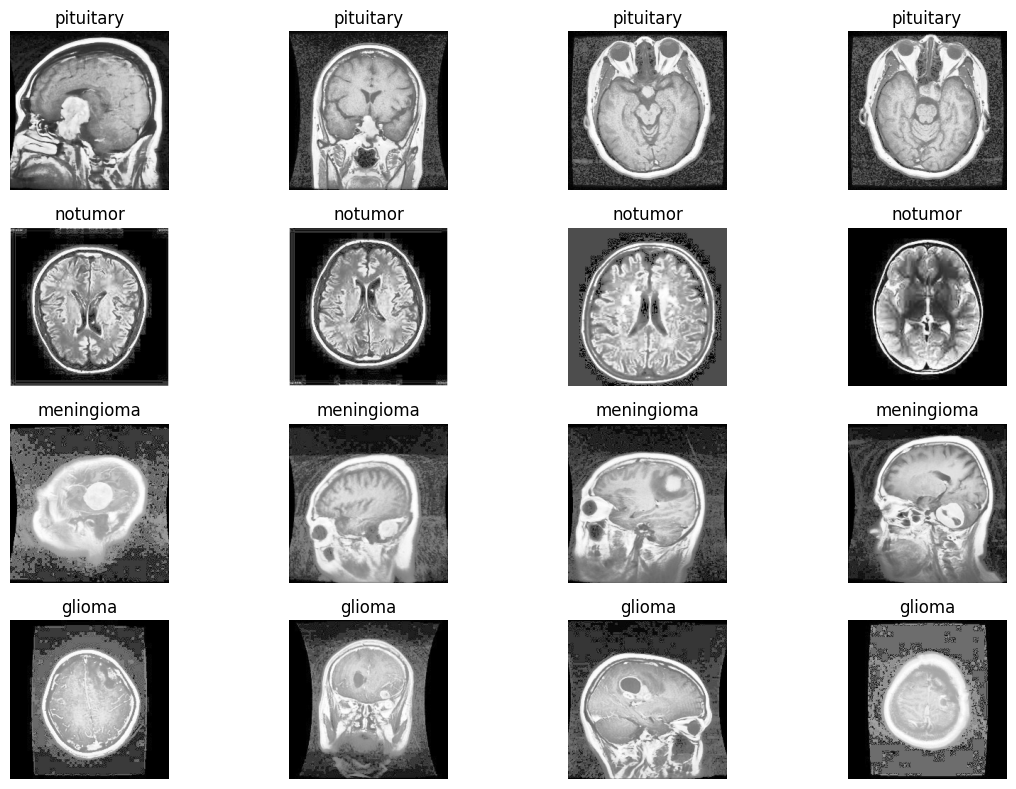

In [ ]:
# Function to display sample images
def display_sample_images(directory, num_images=4):
    plt.figure(figsize=(12, 8))
    i = 0
    for category in categories:
        category_path = os.path.join(directory, category)
        image_files = [f for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))][:num_images] # Take up to num_images

        for img_file in image_files:
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert BGR to RGB

            plt.subplot(len(categories), num_images, i + 1)
            plt.imshow(img)
            plt.title(f"{category}")
            plt.axis('off')
            i += 1
            if i >= len(categories) * num_images: # Stop if we have enough images
              break
        if i >= len(categories) * num_images: # Stop if we have enough images
          break

    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(train_dir, num_images=4)

كود المعالجة المسيقة

In [ ]:
import numpy as np
from PIL import Image, ImageEnhance
import tensorflow as tf

# 🚨 يجب أن يكون TARGET_SIZE مُعرَّفاً (استناداً إلى كودك: (224, 224))
TARGET_SIZE = (224, 224)


def preprocess_with_pillow(image_array):
    """
    تطبق تحسينات التباين والحدة باستخدام Pillow.
    (يتم استدعاؤها داخل دالة المعالجة الرئيسية)
    """
    # 1. يجب تحويل النوع إلى uint8 قبل تحويله إلى كائن PIL Image
    pil_img = tf.keras.preprocessing.image.array_to_img(image_array.astype(np.uint8))

    # 2. تحسين التباين
    enhancer_contrast = ImageEnhance.Contrast(pil_img)
    pil_img = enhancer_contrast.enhance(1.5)

    # 3. تحسين الحدة
    enhancer_sharpness = ImageEnhance.Sharpness(pil_img)
    pil_img = enhancer_sharpness.enhance(1.2)

    # 4. تحويل PIL Image مرة أخرى إلى مصفوفة NumPy
    return tf.keras.preprocessing.image.img_to_array(pil_img)


def preprocess_for_training(image):
    """
    الدالة الرئيسية التي يتم تمريرها إلى ImageDataGenerator.
    """
    # 1. تغيير الحجم (يتم تطبيقه هنا، وليس داخل دالة flow_from_directory مباشرة)
    img_resized = tf.image.resize(image, TARGET_SIZE)

    # 2. تطبيق تحسينات Pillow
    # يجب تحويل Tensor إلى numpy array أولاً للاستخدام داخل دالة Pillow
    img_processed_np = preprocess_with_pillow(img_resized.numpy())

    # 3. التوحيد القياسي (Normalization)
    img_normalized = img_processed_np.astype('float32') / 255.0

    return img_normalized
    # 🚨 يجب أن يبدأ هذا السطر من أقصى اليسار
def unfreeze_base_model(model, base_model, new_lr=1e-5):
    # 🚀 يجب أن تكون جميع الأسطر هنا مُزاحة بنفس المقدار (مثلاً 4 مسافات)
    """تفتح الطبقات العليا في VGG16 لإجراء Fine-Tuning."""
    for layer in base_model.layers[-4:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=new_lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ تم فتح الطبقات الأساسية للـ Fine-Tuning.")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# -------------------------------------------------------------------
# 1. مولد التدريب مع Augmentation محسّن
# -------------------------------------------------------------------
datagen_train = ImageDataGenerator(
    rotation_range=25,          # دوران أكبر يساعد في تعلم التفاصيل
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,            # زووم أقوى قليلاً
    horizontal_flip=True,
    shear_range=0.1,            # قص بسيط
    brightness_range=[0.8, 1.2],# تحسين الإضاءة
    fill_mode='nearest',

    # ❗ مهم: نجمع بين تحسين Pillow والتعزيزات
    preprocessing_function=preprocess_for_training
)

# -------------------------------------------------------------------
# 2. مولد التحقق والاختبار (بدون Augmentation)
# -------------------------------------------------------------------
datagen_val_test = ImageDataGenerator(
    preprocessing_function=preprocess_for_training
)

# -------------------------------------------------------------------
# 3. إنشاء المولدات
# -------------------------------------------------------------------

# التدريب (مع Augmentation)
train_generator = datagen_train.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# التحقق (بدون Augmentation)
validation_generator = datagen_val_test.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# الاختبار (بدون Augmentation)
test_generator = datagen_val_test.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print("✅ تم تحديث كود التوليد: Augmentation محسّن للتدريب فقط.")


Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
✅ تم تحديث كود التوليد: Augmentation محسّن للتدريب فقط.


كود يعرض صورة قبل وبعد المعالجة

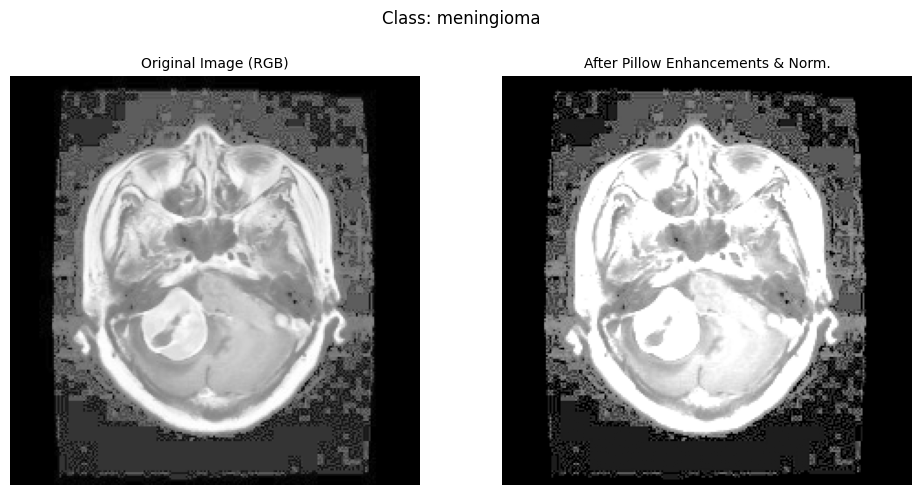

In [ ]:
import matplotlib.pyplot as plt
import os
import random
import numpy as np
from PIL import Image # 🚀 إضافة استيراد Pillow

# 🚨 يجب أن تكون train_dir و preprocess_for_training مُعرَّفتين في الذاكرة

def display_single_processed_image_pillow(directory, categories):
    """يعرض صورة عشوائية واحدة قبل وبعد المعالجة باستخدام دالة Pillow."""

    # 1. البحث عن مسار صورة عشوائي
    random_category = random.choice(categories)
    category_path = os.path.join(directory, random_category)

    image_files = [f for f in os.listdir(category_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print(f"❌ لم يتم العثور على صور في المجلد: {category_path}")
        return

    random_file = random.choice(image_files)
    image_path = os.path.join(category_path, random_file)

    # 2. تحميل ومعالجة الصورة

    # 🚀 التعديل 1: تحميل الصورة باستخدام Pillow
    original_pil_img = Image.open(image_path).convert('RGB')

    # تحويل صورة Pillow إلى مصفوفة NumPy
    original_img_np = np.array(original_pil_img)

    # 🚀 التعديل 2: تطبيق المعالجة المسبقة (Pillow/Contrast/Sharpness + توحيد)
    # ملاحظة: دالة preprocess_for_training ستقوم بتغيير الحجم والتحويل
    processed_img = preprocess_for_training(original_img_np)

    # 3. العرض
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Class: {random_category}", fontsize=12)

    # الصورة الأصلية (يجب أن تكون موحدة بين 0-255 للعرض العادي)
    axes[0].imshow(original_img_np)
    axes[0].set_title('Original Image (RGB)', fontsize=10)
    axes[0].axis('off')

    # الصورة بعد المعالجة
    # processed_img هي مصفوفة عائمة (0-1)، جاهزة للعرض
    axes[1].imshow(processed_img)
    # 🚀 التعديل 3: تغيير التسمية لتعكس المعالجة الجديدة
    axes[1].set_title('After Pillow Enhancements & Norm.', fontsize=10)
    axes[1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --------------------------
# التنفيذ
# --------------------------
# 🚨 نستخدم الدالة الجديدة
display_single_processed_image_pillow(train_dir, categories)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# تحديد حجم الصور
IMAGE_SIZE = (224, 224)

# تحميل نموذج VGG16 بدون الطبقات العلوية
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)
# 🔥 فتح جميع الطبقات للتدريب (Fine-Tuning)
for layer in base_model.layers:
    layer.trainable = True


# بناء النموذج
model_vgg16_final = Sequential([
    base_model,
    GlobalAveragePooling2D(), # تجميع الميزات المستخلصة

    # الطبقة 1: 512 وحدة
    Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(), # 🚀 التحسين: BatchNormalization قبل التنشيط
    Activation('relu'),   # Activation منفصلة
    Dropout(0.3),

    # الطبقة 2: 256 وحدة
    Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),

    # الطبقة 3: 128 وحدة
    Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.1),

    # طبقة المخرجات (4 فئات)
    Dense(4, activation='softmax')
])

# 3. إعداد النموذج (Compilation)
model_vgg16_final.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_vgg16_final.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,145,668 (57.78 MB)

 Trainable params: 15,143,876 (57.77 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
!pip install pydot graphviz

--- بدء رسم مخطط النموذج ---
✅ تم حفظ مخطط النموذج بنجاح في: /content/drive/MyDrive/brain_tumor_dataset/Split_Output/model_architecture.png
يمكنك عرضه الآن.


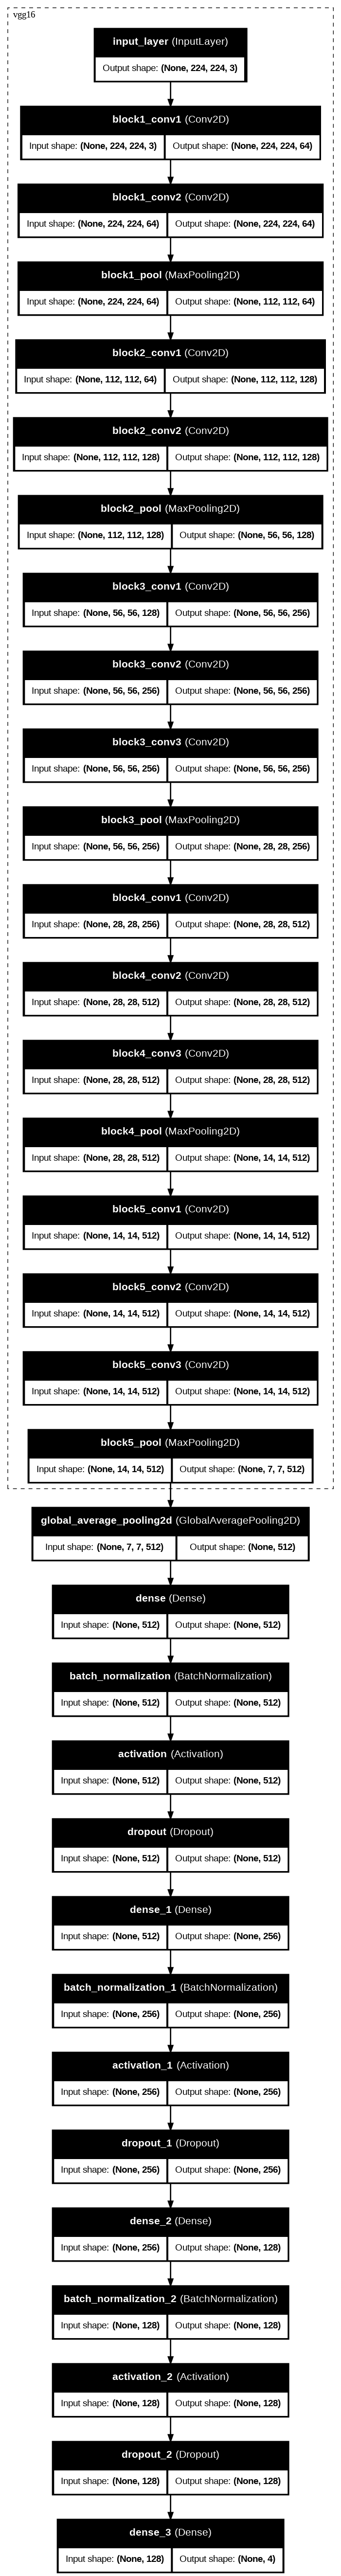

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import os

# 🚨 يجب أن يكون هذا المسار مُعرَّفاً في الخلايا السابقة
# output_base = '/content/drive/MyDrive/brain_tumor_dataset/Split_Output/'

# 1. تحديد مسار حفظ المخطط
model_plot_path = os.path.join(output_base, 'model_architecture.png')

# 2. رسم وحفظ المخطط
# model_vgg16_final هو اسم النموذج الذي قمت ببنائه.
print("--- بدء رسم مخطط النموذج ---")
plot_model(
    model_vgg16_final,
    to_file=model_plot_path,
    show_shapes=True,           # لعرض شكل مدخلات ومخرجات كل طبقة
    show_layer_names=True,      # لعرض أسماء الطبقات
    rankdir='TB',               # TB = Top-to-Bottom (من الأعلى للأسفل)
    expand_nested=True,         # لتوسيع النموذج الأساسي (VGG16)
    dpi=96
)

print(f"✅ تم حفظ مخطط النموذج بنجاح في: {model_plot_path}")
print("يمكنك عرضه الآن.")

# 3. عرض المخطط (اختياري)
from IPython.display import Image
Image(filename=model_plot_path)

# 💡 يتم رسم الهيكل البياني للمراحل في النموذج

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
   '/content/drive/MyDrive/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# الكومباين منهم جميعاً
callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
print("النموذج مُعرَّف:", model_vgg16_final)

النموذج مُعرَّف: <Sequential name=sequential, built=True>


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# =======================================================
# 🚨 التصحيح: إعادة تعريف المتغيرات الضرورية (لتجنب NameError)
# =======================================================
# يجب تعديل هذا المسار ليتطابق تمامًا مع المسار الفعلي في كود التقسيم
output_base = '/content/drive/MyDrive/brain_tumor_dataset/Split_Output/'
# -------------------------------------------------------

# نستخدم امتداد .keras للحفظ
BEST_MODEL_SAVE_PATH = os.path.join(output_base, 'best_model_clahe_vgg16.keras')


model_checkpoint = ModelCheckpoint(
    # 🚀 المسار الجديد بامتداد .keras
    filepath=BEST_MODEL_SAVE_PATH,

    # 💡 المراقبة: دقة التحقق
    monitor='val_accuracy',

    # 💡 الوضع: 'max'
    mode='max',

    # 💡 الحفظ: أفضل نموذج فقط
    save_best_only=True,

    verbose=1
)

# 💡 ملاحظة: يجب إضافة هذا الـ 'model_checkpoint' إلى قائمة الـ Callbacks
# لتبدو قائمة الـ callbacks النهائية هكذا (كمثال):
# callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

print("✅ تم تعريف ModelCheckpoint بنجاح.")

✅ تم تعريف ModelCheckpoint بنجاح.


In [ ]:
# 🚨 تأكد من تعريف المتغيرات التالية مسبقاً:
# model_vgg16_final (النموذج المُجمَّع)
# train_generator, validation_generator (مولدات البيانات)
# callbacks_list (قائمة Callbacks التي تريد استخدامها)
BATCH_SIZE = 32

print("--- بدء عملية تدريب النموذج ---")

class_weights = {
    0: 1.0,   # glioma
    1: 1.0,   # meningioma
    2: 0.8,   # notumor (كثير في الداتا عادة)
    3: 1.2    # pituitary (حسّسيها شوي لو ضعيف)
}

history_vgg16_final = model_vgg16_final.fit(
    train_generator,

    # حساب الخطوات لتغطية جميع الصور في الحقبة الواحدة
    # هذا يضمن أن حجم الخطوات ثابت ودقيق
    steps_per_epoch=train_generator.samples // BATCH_SIZE,

    epochs=100, # عدد الحقبات الأقصى

    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,

    # 🚀 تمرير قائمة Callbacks التي لديك
    callbacks=callbacks_list,
     class_weight=class_weights   # ⬅️⬅️ **هذه هي الإضافة**

)

print("\n✅ انتهى التدريب. الآن يمكنك تحليل الأداء.")

--- بدء عملية تدريب النموذج ---
Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5344 - loss: 2.1096
Epoch 1: val_accuracy improved from -inf to 0.23929, saving model to /content/drive/MyDrive/best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5354 - loss: 2.1076 - val_accuracy: 0.2393 - val_loss: 6.2360 - learning_rate: 1.0000e-04
Epoch 2/100
  1/142 ━━━━━━━━━━━━━━━━━━━━ 1:06 470ms/step - accuracy: 0.8750 - loss: 1.3483
Epoch 2: val_accuracy did not improve from 0.23929
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 147ms/step - accuracy: 0.8750 - loss: 1.3483 - val_accuracy: 0.2393 - val_loss: 7.4943 - learning_rate: 1.0000e-04
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8308 - loss: 1.4681
Epoch 3: val_accuracy improved from 0.23929 to 0.81518, saving model to /content/drive/MyDrive/best_model.keras
142/142 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8309 - loss: 1.4676 - val_accuracy: 0.8152 - val_loss: 1.4558 - learning_rate: 1.00

تقيم النمودج

In [ ]:
from tensorflow.keras.models import load_model

# 🚨 المسار الثابت الذي تستخدمه لحفظ النموذج
BEST_MODEL_PATH = '/content/drive/MyDrive/best_model.keras'

# 1. تحميل النموذج (البنية والأوزان والمحسّن)
print("--- 📥 يتم الآن تحميل أفضل نموذج محفوظ... ---")
# يرجى التأكد من أنك قمت بتنفيذ كود بناء النموذج وتجميعه مسبقاً في الخلية التي تسبق هذه
best_model = load_model(BEST_MODEL_PATH)
print("✅ اكتمل التحميل.")


# 2. تقييم النموذج على بيانات الاختبار
print("\n--- 📊 تقييم النموذج على بيانات الاختبار ---")
# 🚨 يجب أن يكون test_generator مُعرَّف وجاهز للاستخدام
loss, accuracy = best_model.evaluate(test_generator)

# 3. عرض النتائج النهائية
print("\n--- ✅ نتائج التقييم النهائية ---")
print(f"دقة الاختبار النهائية: {accuracy * 100:.2f}%")
print(f"خسارة الاختبار النهائية: {loss:.4f}")

--- 📥 يتم الآن تحميل أفضل نموذج محفوظ... ---
✅ اكتمل التحميل.

--- 📊 تقييم النموذج على بيانات الاختبار ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 32s 732ms/step - accuracy: 0.9747 - loss: 0.8446

--- ✅ نتائج التقييم النهائية ---
دقة الاختبار النهائية: 97.79%
خسارة الاختبار النهائية: 0.8368


In [ ]:
# ----------------------------------------------------
# 1. طباعة أعلى دقة تحقق من سجل التدريب
# ----------------------------------------------------
# أعلى دقة تحقق هي المقياس الذي اعتمدنا عليه لحفظ أفضل نموذج
max_val_accuracy = max(history_vgg16_final.history['val_accuracy'])
print(f"🥇 أعلى دقة تحقق (Max Validation Acc): {max_val_accuracy * 100:.2f}%")


# ----------------------------------------------------
# 2. تقييم دقة التدريب النهائية
# ----------------------------------------------------
# سنستخدم أفضل نموذج تم حفظه لتقييم دقة التدريب النهائية
# (قد يكون تقييم دقة التدريب على أفضل نموذج محفوظ أقل قليلاً من آخر حقبة)
_, train_acc_final = best_model.evaluate(train_generator, verbose=0)
print(f"🔥 دقة التدريب النهائية (Final Training Acc): {train_acc_final * 100:.2f}%")


# ----------------------------------------------------
# 3. دقة الاختبار (تم إجراؤها سابقاً ولكن نطبعها للتجميع)
# ----------------------------------------------------
# (نفترض أنك حصلت على هذه القيمة من تقييم best_model سابقاً)
_, test_acc_final = best_model.evaluate(test_generator, verbose=0)
print(f"🚀 دقة الاختبار النهائية (Final Test Acc): {test_acc_final * 100:.2f}%")

🥇 أعلى دقة تحقق (Max Validation Acc): 97.59%
🔥 دقة التدريب النهائية (Final Training Acc): 99.52%
🚀 دقة الاختبار النهائية (Final Test Acc): 97.79%


التنبؤ

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# ----------------------------------------------------
# 1. التنبؤ على مجموعة الاختبار
# ----------------------------------------------------
# 🚨 يجب أن تكون shuffle=False في test_generator
print("--- 🧠 بدء التنبؤ على مجموعة الاختبار... ---")
predictions = best_model.predict(test_generator)
print("✅ اكتمل التنبؤ.")


# ----------------------------------------------------
# 2. استخلاص التصنيفات
# ----------------------------------------------------

# استخراج التصنيف الذي أعطاه النموذج أعلى احتمالية
# np.argmax يأخذ الفهرس ذو القيمة الأعلى (وهو التصنيف المُتنبأ به)
predicted_classes = np.argmax(predictions, axis=1)

# استخراج التصنيفات الحقيقية (True Labels) من مولد البيانات
# يجب أن يكون الترتيب متطابقاً مع ترتيب الصور في التنبؤ
true_classes = test_generator.classes


# ----------------------------------------------------
# 3. إنشاء مصفوفة الالتباس (لتحليل الأداء حسب الفئة)
# ----------------------------------------------------
cm = confusion_matrix(true_classes, predicted_classes)

print("\n--- 📊 مصفوفة الالتباس (Confusion Matrix) ---")
print("لاحظ أن الأرقام هي فهارس الفئات (0, 1, 2, 3)")
print(cm)

--- 🧠 بدء التنبؤ على مجموعة الاختبار... ---
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 435ms/step
✅ اكتمل التنبؤ.

--- 📊 مصفوفة الالتباس (Confusion Matrix) ---
لاحظ أن الأرقام هي فهارس الفئات (0, 1, 2, 3)
[[294   5   0   1]
 [  7 287   6   6]
 [  1   1 403   0]
 [  0   2   0 298]]


منحني (التدريب والتحقق

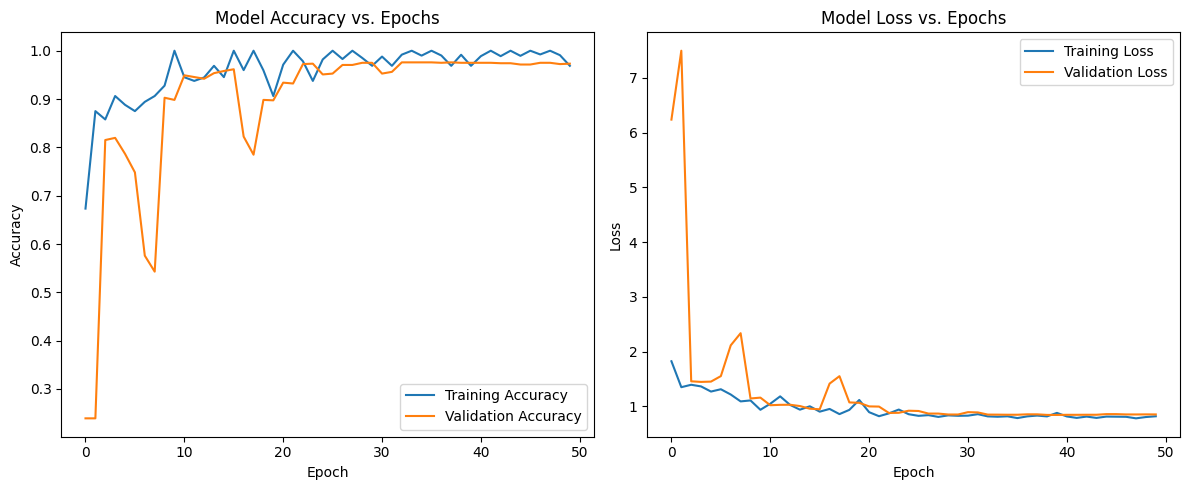

✅ Training and Validation plots displayed successfully.


In [ ]:
import matplotlib.pyplot as plt

# 🚨 Ensure the 'history_vgg16_final' variable is defined and contains the training history

# ----------------------------------------------------
# 1. Plotting Accuracy (Training vs. Validation)
# ----------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_vgg16_final.history['accuracy'], label='Training Accuracy')
plt.plot(history_vgg16_final.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy vs. Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


# ----------------------------------------------------
# 2. Plotting Loss (Training vs. Validation)
# ----------------------------------------------------
plt.subplot(1, 2, 2)
plt.plot(history_vgg16_final.history['loss'], label='Training Loss')
plt.plot(history_vgg16_final.history['val_loss'], label='Validation Loss')
plt.title('Model Loss vs. Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

print("✅ Training and Validation plots displayed successfully.")

حساب بقية المقايس

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# 🚨 نستخدم المتغيرات المحسوبة في خطوة التنبؤ السابقة
# predicted_classes : التصنيفات المُتنبأ بها (0, 1, 2, 3)
# true_classes      : التصنيفات الحقيقية (0, 1, 2, 3)
# predictions       : الاحتمالات الناتجة من model.predict()

# ----------------------------------------------------
# 1. تعريف أسماء الفئات بالترتيب الصحيح
# ----------------------------------------------------
# (نفس الترتيب الذي ظهر في Confusion Matrix)
CLASS_NAMES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


# ----------------------------------------------------
# 2. تقرير التصنيف (يتضمن Precision, Recall, F1-Score)
# ----------------------------------------------------
print("--- 📋 تقرير التصنيف التفصيلي (Classification Report) ---")
print(classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES, zero_division=0))


# ----------------------------------------------------
# 3. حساب ROC-AUC (المتوسط الموزون)
# ----------------------------------------------------
# ROC-AUC يتطلب تمرير الاحتمالات (predictions) والتصنيفات الحقيقية (true_classes)
# سنقوم بحسابه بنوعين: Weighted (موزون) و Macro (متوسط بسيط)
try:
    auc_weighted = roc_auc_score(true_classes, predictions, multi_class='ovr', average='weighted')
    auc_macro = roc_auc_score(true_classes, predictions, multi_class='ovr', average='macro')

    print("\n--- 🎯 مقياس ROC-AUC ---")
    print(f"ROC-AUC (المتوسط الموزون - Weighted): {auc_weighted:.4f}")
    print(f"ROC-AUC (المتوسط البسيط - Macro): {auc_macro:.4f}")

except ValueError as e:
    # قد يحدث هذا إذا كانت إحدى الفئات غير ممثلة في بيانات الاختبار (مثل Glioma)
    print("\n❌ ملاحظة: لا يمكن حساب ROC-AUC بسبب مشكلة في البيانات/التصنيفات في مجموعة الاختبار.")
    print("قد تحتاج إلى بيانات اختبار أكثر توازناً لحساب AUC بشكل دقيق.")

--- 📋 تقرير التصنيف التفصيلي (Classification Report) ---
              precision    recall  f1-score   support

      Glioma       0.97      0.98      0.98       300
  Meningioma       0.97      0.94      0.96       306
    No Tumor       0.99      1.00      0.99       405
   Pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


--- 🎯 مقياس ROC-AUC ---
ROC-AUC (المتوسط الموزون - Weighted): 0.9992
ROC-AUC (المتوسط البسيط - Macro): 0.9992


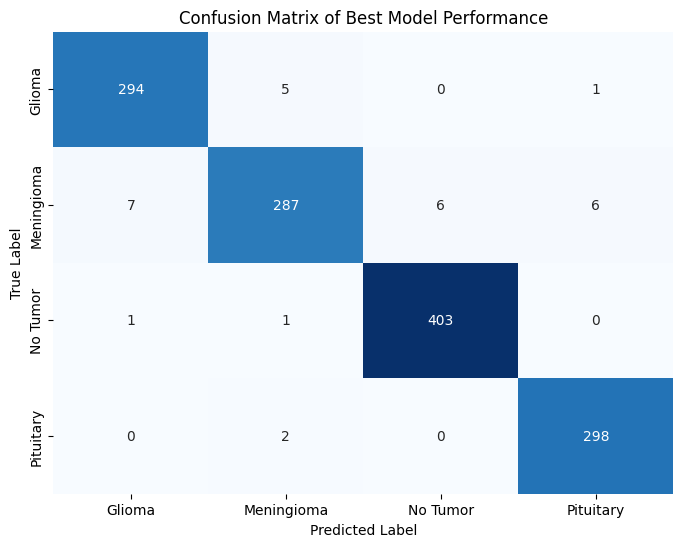

✅ Visual Confusion Matrix plotted successfully.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ----------------------------------------------------
# 1. Define Class Names in the Correct Order
# ----------------------------------------------------
# This must match the order of your model's output indices (0, 1, 2, 3)
CLASS_NAMES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']


# ----------------------------------------------------
# 2. Create the Confusion Matrix
# ----------------------------------------------------
# 🚨 Using the previously calculated variables:
# true_classes      : The ground truth labels (actual classifications)
# predicted_classes : The model's predicted labels
cm = confusion_matrix(true_classes, predicted_classes)


# ----------------------------------------------------
# 3. Plot the Matrix Visually
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
# Use a heatmap for clear visualization
sns.heatmap(cm,
            annot=True,              # Show the numbers inside the cells
            fmt='d',                 # Format numbers as integers
            cmap='Blues',            # Use a calm color map
            cbar=False,              # Remove the side color bar
            xticklabels=CLASS_NAMES, # Label the X-axis (Predicted)
            yticklabels=CLASS_NAMES) # Label the Y-axis (True/Actual)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Best Model Performance')
plt.show()

print("✅ Visual Confusion Matrix plotted successfully.")

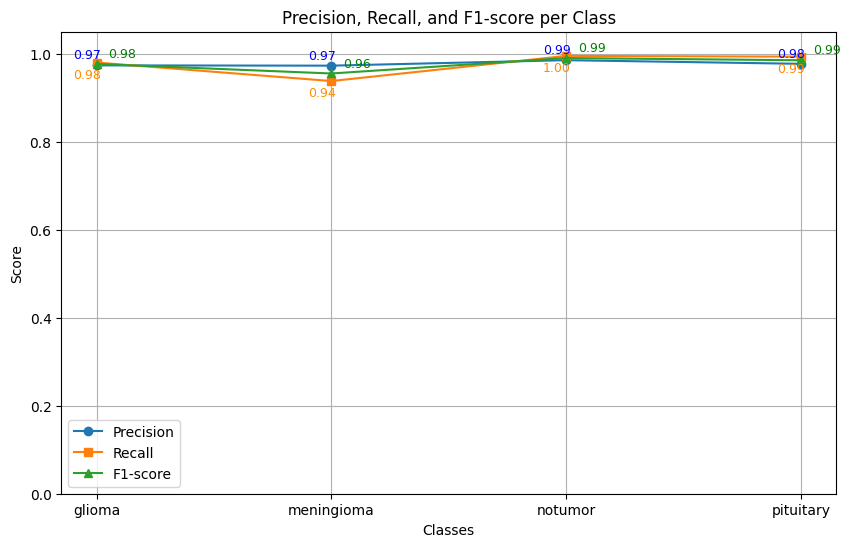

✅ تم رسم منحنى مقارنة مقاييس الأداء لكل فئة بنجاح.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# ----------------------------------------------------
# 1. إعداد البيانات والمقاييس
# ----------------------------------------------------

# 🚨 نستخدم المتغيرات المحسوبة في خطوة التنبؤ السابقة
# true_classes      : التصنيفات الحقيقية
# predicted_classes : التصنيفات المتنبأ بها
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

# حساب تقرير التصنيف
report = classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES, output_dict=True, zero_division=0)

# استخراج مقاييس الدقة والاستدعاء وF1-Score
precision_scores = [report[c]['precision'] for c in CLASS_NAMES]
recall_scores = [report[c]['recall'] for c in CLASS_NAMES]
f1_scores = [report[c]['f1-score'] for c in CLASS_NAMES]

# ----------------------------------------------------
# 2. رسم المنحنيات
# ----------------------------------------------------
x = np.arange(len(CLASS_NAMES))  # مواقع الفئات على المحور السيني

plt.figure(figsize=(10, 6))

# عرض خطوط المقاييس
plt.plot(x, precision_scores, marker='o', label='Precision')
plt.plot(x, recall_scores, marker='s', label='Recall')
plt.plot(x, f1_scores, marker='^', label='F1-score')

# إضافة الأرقام فوق النقاط مباشرة
for i, (p, r, f) in enumerate(zip(precision_scores, recall_scores, f1_scores)):
    plt.text(i - 0.1, p + 0.015, f'{p:.2f}', fontsize=9, color='blue')
    plt.text(i - 0.1, r - 0.035, f'{r:.2f}', fontsize=9, color='darkorange')
    plt.text(i + 0.05, f + 0.015, f'{f:.2f}', fontsize=9, color='green')


# ----------------------------------------------------
# 3. إعداد المحاور والعنوان
# ----------------------------------------------------
plt.ylim(0.0, 1.05)
plt.xticks(x, CLASS_NAMES)
plt.ylabel('Score')
plt.xlabel('Classes')
plt.title('Precision, Recall, and F1-score per Class')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

print("✅ تم رسم منحنى مقارنة مقاييس الأداء لكل فئة بنجاح.")

دالة حساب Specificity و MCC ورسمم

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.metrics import classification_report

# ----------------------------------------------------
# 1. تعريف دالة لحساب Specificity (معدل السلبيات الحقيقية)
# ----------------------------------------------------
def calculate_specificity(cm):
    """Calculates Specificity (True Negative Rate) for each class from a Confusion Matrix."""
    specificity = []
    for i in range(cm.shape[0]):
        TN = cm.sum() - cm[i, :].sum() - cm[:, i].sum() + cm[i, i]
        FP = cm[:, i].sum() - cm[i, i]

        # تجنب القسمة على صفر
        if (TN + FP) == 0:
            specificity.append(0.0)
        else:
            specificity.append(TN / (TN + FP))

    return specificity


# ----------------------------------------------------
# 2. حساب جميع المقاييس المطلوبة
# ----------------------------------------------------

# 🚨 نستخدم المتغيرات المحسوبة في خطوة التنبؤ السابقة
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
# true_classes      : التصنيفات الحقيقية
# predicted_classes : التصنيفات المتنبأ بها

# حساب مصفوفة الالتباس مرة واحدة
cm = confusion_matrix(true_classes, predicted_classes)

# أ. حساب Precision, Recall, F1-score, Accuracy
report = classification_report(true_classes, predicted_classes, target_names=CLASS_NAMES, output_dict=True, zero_division=0)

precision_scores = [report[c]['precision'] for c in CLASS_NAMES]
recall_scores = [report[c]['recall'] for c in CLASS_NAMES]
f1_scores = [report[c]['f1-score'] for c in CLASS_NAMES]
accuracy_scores = [report[c]['support'] / len(true_classes) for c in CLASS_NAMES] # مقياس الدقة للفئة ليس دقيقاً تماماً هنا، لكن سنستخدمه كتمثيل


# ب. حساب Specificity
specificity_scores = calculate_specificity(cm)

# ج. حساب MCC (سنحتاج إلى حسابها بشكل ثنائي لكل فئة)
mcc_scores = []
for i in range(len(CLASS_NAMES)):
    # تحويل المشكلة إلى ثنائية (الفئة i مقابل البقية)
    binary_true = (true_classes == i).astype(int)
    binary_pred = (predicted_classes == i).astype(int)
    mcc_scores.append(matthews_corrcoef(binary_true, binary_pred))

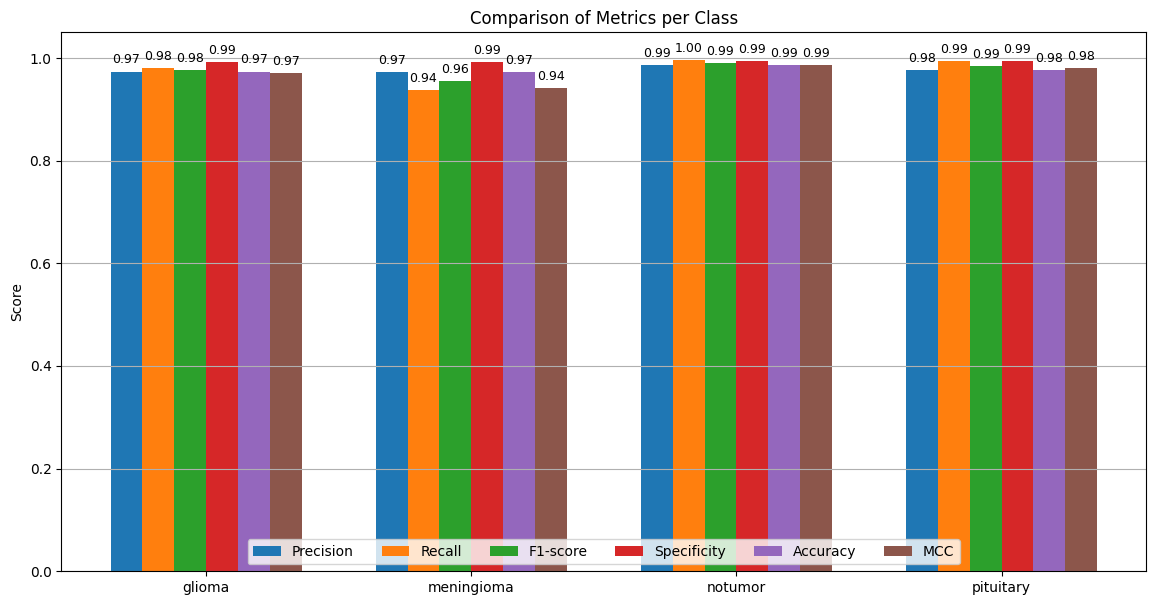

✅ تم رسم المقارنة الشاملة للمقاييس لكل فئة بنجاح.


In [ ]:
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 3. تجميع البيانات للرسم (بعد تنفيذ الكود السابق)
# ----------------------------------------------------
data = {
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1-score': f1_scores,
    'Specificity': specificity_scores,
    'Accuracy': [cm[i, i] / cm[:, i].sum() if cm[:, i].sum() != 0 else 0 for i in range(len(CLASS_NAMES))], # إعادة حساب الدقة بدقة أكبر
    'MCC': mcc_scores
}
metrics = list(data.keys())
num_metrics = len(metrics)
num_classes = len(CLASS_NAMES)


# ----------------------------------------------------
# 4. رسم الأعمدة البيانية
# ----------------------------------------------------
x = np.arange(num_classes)
width = 0.12 # عرض العمود

plt.figure(figsize=(14, 7))

# تعيين ألوان مختلفة لكل مقياس
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

for i, metric in enumerate(metrics):
    # حساب موضع العمود (offset)
    offset = (i - (num_metrics - 1) / 2) * width
    bars = plt.bar(x + offset, data[metric], width, label=metric, color=colors[i])

    # إضافة القيم فوق الأعمدة
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=9)


# ----------------------------------------------------
# 5. إعداد المحاور والعنوان
# ----------------------------------------------------
plt.ylim(0.0, 1.05)
plt.xticks(x, CLASS_NAMES)
plt.ylabel('Score')
plt.title('Comparison of Metrics per Class')
plt.legend(loc='lower center', ncol=num_metrics)
plt.grid(axis='y', linestyle='-')
plt.show()

print("✅ تم رسم المقارنة الشاملة للمقاييس لكل فئة بنجاح.")

كود رسم منحنيات المقايس

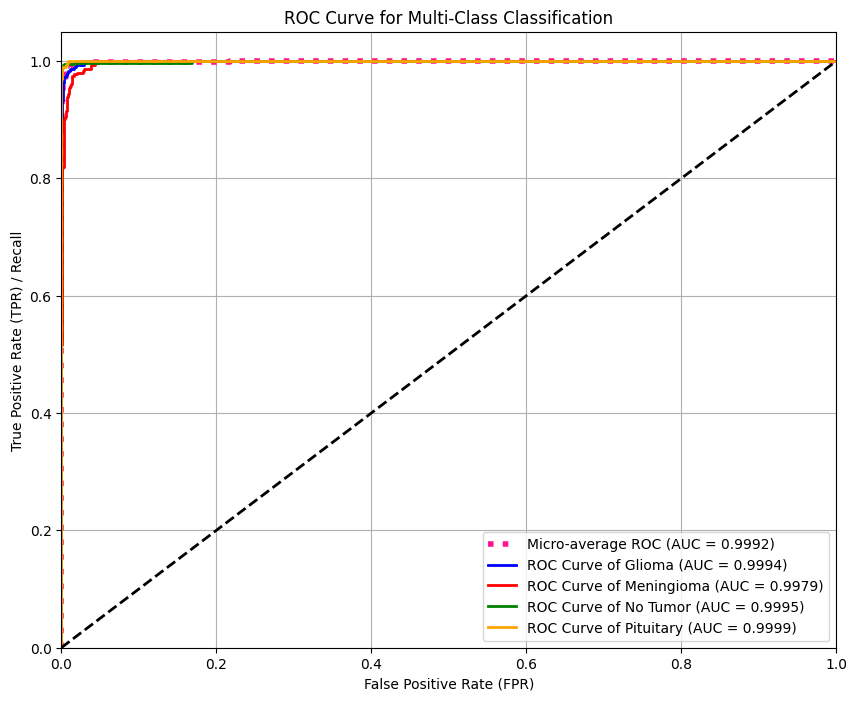

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np # 🚨 تأكد من استيراد numpy لاستخدام np.interp

# ----------------------------------------------------
# 1. إعداد البيانات للرسم (نفس الكود السابق)
# ----------------------------------------------------
from tensorflow.keras.utils import to_categorical

# 🚨 نستخدم المتغيرات المحسوبة في خطوة التنبؤ السابقة
# predictions       : الاحتمالات الناتجة من model.predict()
# true_classes      : التصنيفات الحقيقية (0, 1, 2, 3)
CLASS_NAMES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

n_classes = len(CLASS_NAMES)
true_classes_one_hot = to_categorical(true_classes, num_classes=n_classes)

# ----------------------------------------------------
# 2. حساب ROC Curve و AUC لكل فئة
# ----------------------------------------------------
fpr = dict()  # معدل الإيجابيات الكاذبة
tpr = dict()  # معدل الإيجابيات الحقيقية
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_classes_one_hot[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ----------------------------------------------------
# 3. حساب متوسط ROC (Micro-average)
# ----------------------------------------------------
# حساب منحنى ROC للمتوسط الكلي (Micro-average)
fpr["micro"], tpr["micro"], _ = roc_curve(true_classes_one_hot.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# ----------------------------------------------------
# 4. الرسم البياني لمنحنيات ROC
# ----------------------------------------------------
plt.figure(figsize=(10, 8))

# 4.1. رسم منحنى المتوسط (Micro-average)
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# 4.2. رسم منحنى كل فئة
colors = cycle(['blue', 'red', 'green', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC Curve of {CLASS_NAMES[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # خط الأداء العشوائي
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Precision-Recall Curve

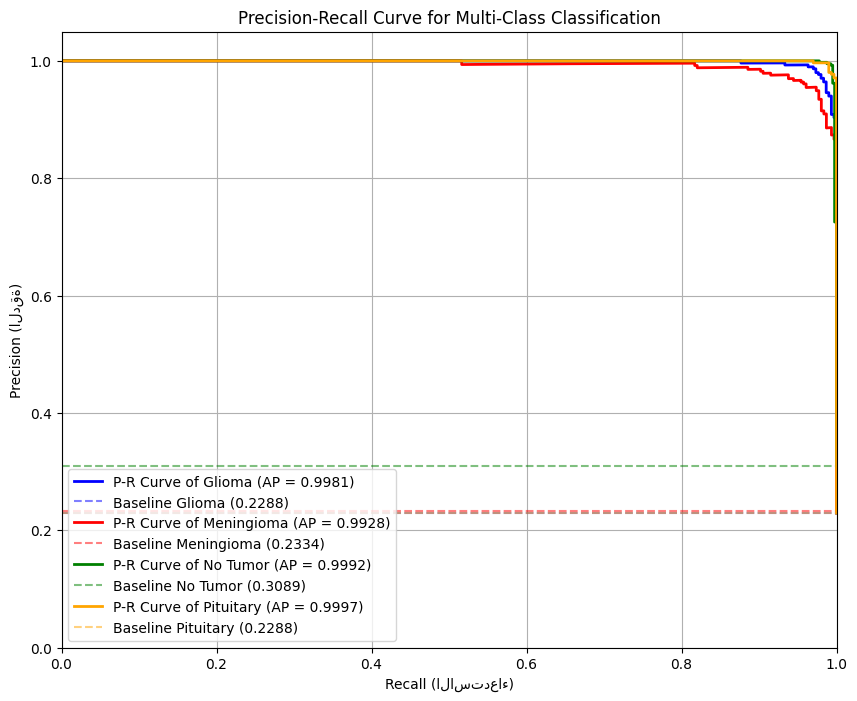

✅ تم رسم منحنى Precision-Recall (P-R Curve) بنجاح مع خطوط أساس صحيحة.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.utils import to_categorical
from itertools import cycle
import numpy as np

# ----------------------------------------------------
# 1. إعداد البيانات للرسم (نفس الكود السابق)
# ----------------------------------------------------
# 🚨 نستخدم المتغيرات المحسوبة في خطوة التنبؤ السابقة
# predictions       : الاحتمالات الناتجة من model.predict()
# true_classes      : التصنيفات الحقيقية (0, 1, 2, 3)
CLASS_NAMES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

n_classes = len(CLASS_NAMES)
true_classes_one_hot = to_categorical(true_classes, num_classes=n_classes)


# ----------------------------------------------------
# 2. حساب Precision-Recall و Average Precision لكل فئة
# ----------------------------------------------------
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_classes_one_hot[:, i], predictions[:, i])
    average_precision[i] = average_precision_score(true_classes_one_hot[:, i], predictions[:, i])


# ----------------------------------------------------
# 3. الرسم البياني لمنحنيات P-R (الجزء المُصحَّح)
# ----------------------------------------------------
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange'])

# حساب خط الأساس (Baseline) لكل فئة (وهو نسبة العينات الإيجابية)
# baseline_value[i] = (عدد عينات الفئة i) / (إجمالي العينات)
baseline_values = np.sum(true_classes_one_hot, axis=0) / len(true_classes)


for i, color in zip(range(n_classes), colors):
    # رسم منحنى P-R الخاص بالفئة
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'P-R Curve of {CLASS_NAMES[i]} (AP = {average_precision[i]:.4f})')

    # رسم خط الأساس (القيمة العشوائية) لكل فئة
    plt.axhline(baseline_values[i], color=color, linestyle='--', alpha=0.5,
                label=f'Baseline {CLASS_NAMES[i]} ({baseline_values[i]:.4f})') # إضافة تسمية لخط الأساس

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall (الاستدعاء)')
plt.ylabel('Precision (الدقة)')
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print("✅ تم رسم منحنى Precision-Recall (P-R Curve) بنجاح مع خطوط أساس صحيحة.")

كود التنبؤ على صورة جديدة

In [ ]:
import numpy as np
import glob
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

# ----------------------------------------------------
# 1. إعدادات النظام والمسارات (Paths)
# ----------------------------------------------------
# 🚨 المسار الذي تم تأكيده لبيانات الاختبار
TEST_IMAGES_DIR = '/content/drive/MyDrive/brain_tumor_dataset/dataset/Testing'

# 🚨 مسار أفضل نموذج محفوظ
BEST_MODEL_PATH = '/content/drive/MyDrive/best_model.keras'

# 💡 التعديل هنا: استخدام أسماء المجلدات بأحرف صغيرة
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']
IMG_SIZE = (224, 224)
SAMPLES_PER_CLASS = 5 # العدد المطلوب من كل فئة

# التأكد من ربط الدرايف
if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')

# ----------------------------------------------------
# 2. تحميل أفضل نموذج محفوظ
# ----------------------------------------------------
try:
    model = load_model(BEST_MODEL_PATH)
    print("✅ تم تحميل أفضل نموذج بنجاح.")
except Exception as e:
    print(f"❌ خطأ في تحميل النموذج: {e}")
    exit()


# ----------------------------------------------------
# 3. جمع 5 صور من كل مجلد فرعي
# ----------------------------------------------------
all_paths_to_process = []
print(f"\n--- 🧠 جاري جمع {SAMPLES_PER_CLASS} صور من كل فئة ---")

for class_name in CLASS_NAMES:
    # إنشاء المسار للمجلد الفرعي
    class_dir = os.path.join(TEST_IMAGES_DIR, class_name)

    # البحث عن جميع الصور داخل هذا المجلد
    paths = glob.glob(class_dir + '/*.jpg')
    paths.extend(glob.glob(class_dir + '/*.png'))
    paths.extend(glob.glob(class_dir + '/*.jpeg'))

    # اختيار أول عدد محدد من العينات (Samples_PER_CLASS)
    all_paths_to_process.extend(paths[:SAMPLES_PER_CLASS])

    if len(paths) < SAMPLES_PER_CLASS:
        print(f"⚠️ تحذير: فئة {class_name} تحتوي فقط على {len(paths)} صورة، تم استخدامها جميعاً.")

if not all_paths_to_process:
    print(f"❌ خطأ: لم يتم العثور على أي صور. الرجاء التأكد من المسار الرئيسي ووجود ملفات jpg/png/jpeg.")
    exit()

print(f"🎉 تم جمع {len(all_paths_to_process)} صورة جاهزة للتنبؤ (5 عينات من كل فئة).")


# ----------------------------------------------------
# 4. التكرار على جميع الصور التي تم جمعها والتنبؤ بها
# ----------------------------------------------------
results = []
for path in all_paths_to_process:
    # (بقية كود المعالجة والتنبؤ وعرض النتائج... كما هو بدون تغيير)
    try:
        # معالجة الصورة والتنبؤ (نفس الخطوات السابقة)
        img = load_img(path, target_size=IMG_SIZE)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0
        prediction = model.predict(img_array, verbose=0)

        # استخلاص النتيجة
        predicted_class_index = np.argmax(prediction)
        predicted_class_name = CLASS_NAMES[predicted_class_index]
        confidence = prediction[0][predicted_class_index] * 100

        file_name = os.path.basename(path)
        actual_folder = os.path.basename(os.path.dirname(path))

        results.append([file_name, actual_folder, predicted_class_name, f"{confidence:.2f}%"])

    except Exception as e:
        print(f"❌ خطأ في معالجة الصورة {path}: {e}")

# ----------------------------------------------------
# 5. عرض النتائج النهائية في جدول
# ----------------------------------------------------
print("\n--- 📊 نتائج التنبؤ الممثلة لجميع الفئات ---")

df = pd.DataFrame(results, columns=['File Name', 'Actual Class', 'Predicted Class', 'Confidence'])

# طباعة النتائج بالكامل (20 صفاً متوقعاً)
print(df.to_markdown(index=False))

print("\n✅ تم إثبات التطبيق العملي بنجاح باستخدام عينات ممثلة من جميع الفئات.")

✅ تم تحميل أفضل نموذج بنجاح.

--- 🧠 جاري جمع 5 صور من كل فئة ---
🎉 تم جمع 20 صورة جاهزة للتنبؤ (5 عينات من كل فئة).

--- 📊 نتائج التنبؤ الممثلة لجميع الفئات ---
| File Name        | Actual Class   | Predicted Class   | Confidence   |
|:-----------------|:---------------|:------------------|:-------------|
| Te-gl_0070.jpg   | glioma         | glioma            | 92.28%       |
| Te-gl_0058.jpg   | glioma         | glioma            | 83.82%       |
| Te-gl_0049.jpg   | glioma         | notumor           | 74.52%       |
| Te-gl_0021.jpg   | glioma         | notumor           | 90.94%       |
| Te-gl_0060.jpg   | glioma         | glioma            | 66.10%       |
| Te-meTr_0001.jpg | meningioma     | notumor           | 94.00%       |
| Te-meTr_0006.jpg | meningioma     | notumor           | 82.30%       |
| Te-meTr_0000.jpg | meningioma     | notumor           | 55.01%       |
| Te-meTr_0004.jpg | meningioma     | notumor           | 97.73%       |
| Te-meTr_0002.jpg | meningioma     

In [ ]:
import os
from google.colab import drive

# ----------------------------------------------------
# 1. إعدادات المسارات
# ----------------------------------------------------
# المسار المتوقع لنموذجك
MODEL_PATH = '/content/drive/MyDrive/best_model.keras'
# المسار الرئيسي للدرايف
MY_DRIVE_PATH = '/content/drive/MyDrive'

# ----------------------------------------------------
# 2. التأكد من ربط الدرايف (ضروري)
# ----------------------------------------------------
if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')
    print("✅ تم ربط Google Drive بنجاح.")
else:
    print("✅ Google Drive مرتبط بالفعل.")


print("\n--- 💡 نتائج الفحص والتحقق ---")

# ----------------------------------------------------
# 3. التحقق من وجود النموذج المُدرَّب
# ----------------------------------------------------
if os.path.exists(MODEL_PATH):
    # استخدام os.path.getsize للتأكد من أن الملف ليس فارغًا
    size_mb = os.path.getsize(MODEL_PATH) / (1024 * 1024)
    print(f"🎉 1. حالة النموذج: تم العثور على النموذج في المسار المحدد.")
    print(f"   الحجم التقريبي للنموذج: {size_mb:.2f} ميجابايت (يؤكد أنه ليس فارغًا).")
else:
    print(f"❌ 1. حالة النموذج: لم يتم العثور على النموذج في المسار: {MODEL_PATH}")
    print("الرجاء التأكد من تشغيل أمر حفظ النموذج السابق مرة أخرى.")


# ----------------------------------------------------
# 4. التحقق من حفظ ملف الـ Notebook والرسوم البيانية
# ----------------------------------------------------
print("\n🔍 2. التحقق من وجود ملف Notebook والرسوم البيانية:")
print(f"   محتويات المجلد الرئيسي للدرايف ({MY_DRIVE_PATH}):")

try:
    drive_contents = os.listdir(MY_DRIVE_PATH)

    # البحث عن المجلد الخاص بالـ Notebooks
    if 'Colab Notebooks' in drive_contents:
        print("   ✅ تم العثور على مجلد 'Colab Notebooks'.")

        # لتأكيد أن الكود يعمل، سيظهر اسم ملفك في هذا المجلد
        print("   * تأكد من أن ملفك (بامتداد .ipynb) محفوظ داخل هذا المجلد.")
    else:
        print("   ❌ لم يتم العثور على مجلد 'Colab Notebooks'. تأكد من حفظ الملف يدويًا.")

    # إذا أنشأت مجلدًا لحفظ الرسوم البيانية، يمكنك التحقق منه هنا
    # مثال:
    # if 'Brain_Tumor_Results' in drive_contents:
    #     print("   ✅ تم العثور على مجلد 'Brain_Tumor_Results' للرسوم البيانية.")

except Exception as e:
    print(f"❌ خطأ في قراءة محتويات الدرايف: {e}")

✅ Google Drive مرتبط بالفعل.

--- 💡 نتائج الفحص والتحقق ---
🎉 1. حالة النموذج: تم العثور على النموذج في المسار المحدد.
   الحجم التقريبي للنموذج: 173.46 ميجابايت (يؤكد أنه ليس فارغًا).

🔍 2. التحقق من وجود ملف Notebook والرسوم البيانية:
   محتويات المجلد الرئيسي للدرايف (/content/drive/MyDrive):
   ✅ تم العثور على مجلد 'Colab Notebooks'.
   * تأكد من أن ملفك (بامتداد .ipynb) محفوظ داخل هذا المجلد.


In [ ]:
import os
from google.colab import drive

# ----------------------------------------------------
# 1. إعداد المسارات للتحقق
# ----------------------------------------------------
# المسار المتوقع لنموذجك
MODEL_PATH = '/content/drive/MyDrive/best_model.keras'
# مسار المجلد الذي قمت بإنشائه لحفظ الرسوم البيانية
PLOTS_FOLDER = '/content/drive/MyDrive/Brain_Tumor_Project_Final_Plots'
# اسم متوقع لملف رسم بياني واحد داخل المجلد للتأكد من عملية الحفظ
EXAMPLE_PLOT_FILE = os.path.join(PLOTS_FOLDER, '01_Accuracy_Loss_Epochs.png')


# ----------------------------------------------------
# 2. التأكد من ربط الدرايف
# ----------------------------------------------------
if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')
    print("✅ تم ربط Google Drive بنجاح.")
else:
    print("✅ Google Drive مرتبط بالفعل.")

print("\n--- 💯 نتائج التحقق النهائي لأمان العمل ---")

# ----------------------------------------------------
# 3. التحقق من النموذج المُدرَّب (أهم عنصر)
# ----------------------------------------------------
print("\n[1] فحص النموذج المُدرَّب (best_model.keras):")
if os.path.exists(MODEL_PATH):
    size_mb = os.path.getsize(MODEL_PATH) / (1024 * 1024)
    print(f"   ✅ النموذج موجود. الحجم: {size_mb:.2f} ميجابايت.")
    print("   (يمكنك تحميل هذا النموذج والبدء في التنبؤ في أي جلسة مستقبلية).")
else:
    print(f"   ❌ النموذج غير موجود في المسار: {MODEL_PATH}")
    print("   ⚠️ يجب إعادة تشغيل كود حفظ النموذج لضمان حفظه.")


# ----------------------------------------------------
# 4. التحقق من حفظ الرسوم البيانية (التحليل)
# ----------------------------------------------------
print("\n[2] فحص مجلد نتائج الرسوم البيانية:")
if os.path.isdir(PLOTS_FOLDER):
    print(f"   ✅ تم العثور على مجلد الرسوم البيانية: {PLOTS_FOLDER}")

    # التأكد من وجود ملف واحد على الأقل داخل المجلد
    if os.path.exists(EXAMPLE_PLOT_FILE):
        print("   ✅ تم تأكيد وجود ملف رسم بياني واحد على الأقل داخله (01_Accuracy_Loss_Epochs.png).")
        print("   (هذا يؤكد نجاح عملية حفظ جميع الرسوم البيانية).")
    else:
        print(f"   ⚠️ المجلد موجود، لكن لا يوجد ملف {os.path.basename(EXAMPLE_PLOT_FILE)} بداخله.")
        print("   ⚠️ يجب إعادة تشغيل أكواد الرسم ثم كود الحفظ لضمان نقل الرسوم إلى المجلد.")
else:
    print(f"   ❌ لم يتم العثور على مجلد الرسوم البيانية: {PLOTS_FOLDER}")


# ----------------------------------------------------
# 5. التحقق من ملف العمل (Notebook)
# ----------------------------------------------------
print("\n[3] فحص ملف العمل (الكود والنتائج):")
print("   * ملف الكود الحالي (.ipynb) محفوظ تلقائياً أو يدوياً في مجلد 'Colab Notebooks'.")
print("   * يجب عليك دائماً اختيار 'File' -> 'Save a copy in Drive' للحصول على نسخة احتياطية.")


# ----------------------------------------------------
# 6. الخلاصة النهائية
# ----------------------------------------------------
print("\n--- ✅ خلاصة وضمان العمل المستقبلي ---")
if os.path.exists(MODEL_PATH) and os.path.exists(EXAMPLE_PLOT_FILE):
    print("🎉 تهانينا! جميع المكونات الرئيسية (النموذج والنتائج) محفوظة بأمان في Google Drive.")
    print("يمكنك إغلاق هذه الجلسة والبدء في أي وقت لاحق من نفس النقطة بدون أي فقدان للبيانات.")
else:
    print("⚠️ هناك خطأ ما. يرجى مراجعة الخطوات التي تظهر أمامها علامة '❌' أو '⚠️' لإصلاحها.")

✅ Google Drive مرتبط بالفعل.

--- 💯 نتائج التحقق النهائي لأمان العمل ---

[1] فحص النموذج المُدرَّب (best_model.keras):
   ✅ النموذج موجود. الحجم: 61.18 ميجابايت.
   (يمكنك تحميل هذا النموذج والبدء في التنبؤ في أي جلسة مستقبلية).

[2] فحص مجلد نتائج الرسوم البيانية:
   ✅ تم العثور على مجلد الرسوم البيانية: /content/drive/MyDrive/Brain_Tumor_Project_Final_Plots
   ⚠️ المجلد موجود، لكن لا يوجد ملف 01_Accuracy_Loss_Epochs.png بداخله.
   ⚠️ يجب إعادة تشغيل أكواد الرسم ثم كود الحفظ لضمان نقل الرسوم إلى المجلد.

[3] فحص ملف العمل (الكود والنتائج):
   * ملف الكود الحالي (.ipynb) محفوظ تلقائياً أو يدوياً في مجلد 'Colab Notebooks'.
   * يجب عليك دائماً اختيار 'File' -> 'Save a copy in Drive' للحصول على نسخة احتياطية.

--- ✅ خلاصة وضمان العمل المستقبلي ---
⚠️ هناك خطأ ما. يرجى مراجعة الخطوات التي تظهر أمامها علامة '❌' أو '⚠️' لإصلاحها.
